In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem as ch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoLarsCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFECV, SelectFromModel
import pickle as pkl
import seaborn as sns
from scipy.stats import uniform, randint

In [10]:
def split_data(X_new):
    X_final, validate = np.split(X_new.sample(frac=1), [int(.8*len(X_new))])
    X_train, X_test, y_train, y_test = train_test_split(X_final.drop(columns=['pChemBL'],inplace=False), X_final['pChemBL'], test_size=0.2, random_state=42)
    X_validate = validate.drop(columns='pChemBL',inplace=False).copy()
    y_validate = validate['pChemBL']
    return X_train, X_test, X_validate, y_train, y_test, y_validate
def train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate,estimators=150):
    model2 = RandomForestRegressor(n_estimators=estimators)
    model2.fit(X_train,y_train)
    r_square = model2.score(X_train,y_train)
    rmse = np.sqrt(mean_squared_error(model2.predict(X_train),y_train))
    print('Number of estimators = {}'.format(estimators))
    print("Training set results:\nRMSE = {}\t R^2 = {}".format(rmse,r_square))
    q_square = model2.score(X_test,y_test)
    rmse = np.sqrt(mean_squared_error(model2.predict(X_test),y_test))
    print("Test set results\nRMSE = {}\t Q^2 = {}".format(rmse,q_square))
    q_square = model2.score(X_validate,y_validate)
    rmse = np.sqrt(mean_squared_error(y_validate,model2.predict(X_validate)))
    print("Validation set results\nRMSE = {}\t Q^2 = {}".format(rmse,q_square))    
    return model2
def split_train(X,estimators=150):
    X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X)
    model = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate,estimators)
    return model
def get_cols(n):
    cols = []
    for i in range(n):
        cols.append('component'+str(i+1))
    return cols
def scores(y_test,predictions):
    mse=mean_squared_error(preds,y_test)
    y_mean = np.full(shape=y_test.shape,fill_value=y_test.mean())
    mse_ = mean_squared_error(y_mean,y_test)
    print("RMSE = ",np.sqrt(mse))
    print("Q^2 = ",1-(mse/mse_))

In [4]:
X = pd.read_csv('no_zeros_no_chembl.csv')
y = X['pChemBL']
X.drop(columns='pChemBL',inplace=True)

In [5]:
reg = ExtraTreesRegressor(n_estimators=150)
reg = reg.fit(X, y)

In [ ]:
reg.score(X,y)

In [38]:
model = SelectFromModel(reg, prefit=True)
X_new = model.transform(X)
X_new.shape               


(2861, 279)

In [39]:
cols = []
for i in range(X_new.shape[1]):
    cols.append('comp'+str(i+1))
X_new = pd.DataFrame(data=X_new,columns=cols)

In [40]:
X_new['pChemBL'] = y
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_new)
model = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

Training set results:
RMSE = 0.2612342814942656	 R^2 = 0.951231462226615
Test set results
RMSE = 0.6711355166778638	 Q^2 = 0.6546759899619428
Validation set results
RMSE = 0.7139772320201792	 Q^2 = 0.5980952575220048


In [ ]:
X_new = SelectKBest(mutual_info_regression, k=50).fit_transform(X, y)

cols = []
for i in range(50):
    cols.append('comp'+str(i+1))
X_red = pd.DataFrame(data=X_new, columns=cols)

In [33]:
X_red['pChemBL'] = y
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_red)
RFR = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

Training set results:
RMSE = 0.2739322287215124	 R^2 = 0.9468244640055198
Test set results
RMSE = 0.6161916091171696	 Q^2 = 0.7009729340649702
Validation set results
RMSE = 0.6717152615156313	 Q^2 = 0.6397030563793147


In [41]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
ko = 15
X_new = SelectKBest(mutual_info_regression, k=ko).fit_transform(X, y)

cols = []
for i in range(ko):
    cols.append('comp'+str(i+1))
X_red = pd.DataFrame(data=X_new, columns=cols)
X_red['pChemBL'] = y
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_red)
RFR = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

Training set results:
RMSE = 0.2835793651287902	 R^2 = 0.9410312390992518
Test set results
RMSE = 0.6982204063849987	 Q^2 = 0.6342943954025049
Validation set results
RMSE = 0.7285472901564857	 Q^2 = 0.6090261968313742


In [6]:
from sklearn.feature_selection import RFECV
select = RFECV(reg,step =200,n_jobs=-1,min_features_to_select= 50,verbose=1)
select.fit(X,y)
X_new = select.transform(X)

Fitting estimator with 1208 features.
Fitting estimator with 1008 features.
Fitting estimator with 808 features.


In [10]:
cols = []
for i in range(X_new.shape[1]):
    cols.append('comp'+str(i+1))
X_red = pd.DataFrame(data=X_new, columns=cols)
X_red['pChemBL'] = y
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_red)
RFR = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

Training set results:
RMSE = 0.26038643091486924	 R^2 = 0.9506658314566686
Test set results
RMSE = 0.6892970161527208	 Q^2 = 0.6311874891385347
Validation set results
RMSE = 0.7153796013506576	 Q^2 = 0.624192456639348


In [21]:
#X_red.drop(columns='pChemBL',inplace=True)
X_red.head()
X_red.drop(columns='comp50',inplace=True)

In [ ]:
cols = []
for i in range(50):
    cols.append('comp'+str(i+1))
X_new = SelectKBest(mutual_info_regression, k=50).fit_transform(X_red, y)
X_red = pd.DataFrame(data=X_new, columns=cols)

In [22]:
X_red['pChemBL'] = y
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_red)
RFR = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

Training set results:
RMSE = 0.25776643379761544	 R^2 = 0.9506208177595016
Test set results
RMSE = 0.6484785432255382	 Q^2 = 0.6888873283556138
Validation set results
RMSE = 0.6953832131541388	 Q^2 = 0.6545151705403043


In [25]:
cols=[]
for i in range(25):
    cols.append('comp'+str(i+1))
X_red.drop(columns='pChemBL',inplace=True)    
X_new = SelectKBest(mutual_info_regression, k=25).fit_transform(X_red, y)
X_red = pd.DataFrame(data=X_new, columns=cols)
X_red['pChemBL'] = y
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_red)
RFR = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

Training set results:
RMSE = 0.2769289461389025	 R^2 = 0.9442085567589638
Test set results
RMSE = 0.7155156440570092	 Q^2 = 0.6291208962414494
Validation set results
RMSE = 0.6721193455727127	 Q^2 = 0.6449727110165622


<h4> For display/rerun(the best model)

In [3]:
X = pd.read_csv('no_zeros_no_chembl.csv')
y = X['pChemBL']
X.drop(columns='pChemBL',inplace=True)
selections = SelectKBest(mutual_info_regression, k=50)
X_new = selections.fit_transform(X, y)
cols = []
for i in range(50):
    cols.append('comp'+str(i+1))
X_red = pd.DataFrame(data=X_new, columns=cols)
X_red['pChemBL'] = y

In [10]:
#DONE WITHOUT THE CORRELATION DROP
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_red)
RFR = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

Training set results:
RMSE = 0.2683276019767677	 R^2 = 0.9467019849913931
Test set results
RMSE = 0.7066172160204794	 Q^2 = 0.6299947142698358
Validation set results
RMSE = 0.610511017731687	 Q^2 = 0.7289860444995122


(array([13., 14.,  3., 12.,  2.,  3.,  1.,  1.,  0.,  1.]),
 array([0.00261609, 0.02989528, 0.05717446, 0.08445364, 0.11173283,
        0.13901201, 0.1662912 , 0.19357038, 0.22084956, 0.24812875,
        0.27540793]),
 <a list of 10 Patch objects>)

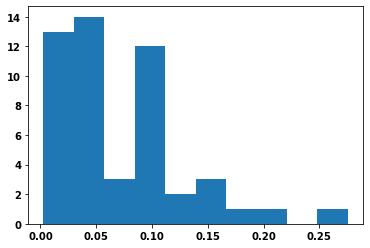

In [6]:
correlation_matrix = X_red.corr()
plt.hist(correlation_matrix.abs().iloc[:50,50])

In [8]:
bad_cols_index = []
for cols in range(50):
    if correlation_matrix.abs().iloc[cols,50] < 0.05:
        bad_cols_index.append(cols)
print(len(bad_cols_index))

bad_cols2 = []
cols = X_red.columns
for index in bad_cols_index:
    bad_cols2.append(cols[index])
len(bad_cols2)
X_red.drop(columns=bad_cols2,inplace=True)

25


In [10]:
RFR = split_train(X_red)

Number of estimators = 150
Training set results:
RMSE = 0.26519421658207476	 R^2 = 0.9474568730648255
Test set results
RMSE = 0.6802567400441033	 Q^2 = 0.6573440459185296
Validation set results
RMSE = 0.7221868262836015	 Q^2 = 0.6334668795037086


In [74]:
cols = selections.get_support(indices=True)
good_columns = []
all_columns = X.columns
for i in range(len(all_columns)):
    if i in cols:
        good_columns.append(X.columns[i])
print(good_columns)

['naAromAtom', 'nAromBond', 'BCUTc-1l', 'BCUTc-1h', 'BCUTp-1h', 'SpMax1_Bhm', 'SpMin1_Bhm', 'SpMin3_Bhm', 'SpMax1_Bhv', 'SpMax2_Bhv', 'SpMin1_Bhv', 'SpMin7_Bhv', 'SpMax1_Bhe', 'SpMax3_Bhe', 'SpMin1_Bhe', 'SpMin2_Bhe', 'SpMin4_Bhe', 'SpMin6_Bhe', 'SpMin8_Bhe', 'SpMax1_Bhp', 'SpMax2_Bhp', 'SpMax3_Bhp', 'SpMin1_Bhp', 'SpMax1_Bhi', 'SpMin1_Bhi', 'SpMin2_Bhi', 'C2SP2', 'SCH-6', 'VCH-5', 'SpMAD_Dt', 'SHaaCH', 'SaaN', 'minHBa', 'maxaaN', 'HybRatio', 'nAtomP', 'MDEN-22', 'MDEN-23', 'MLFER_A', 'MLFER_BH', 'piPC5', 'piPC7', 'piPC8', 'piPC9', 'piPC10', 'TpiPC', 'R_TpiPCTPC', 'nTRing', 'WTPT-4', 'WTPT-5']


In [75]:
len(good_columns)

50

<h3>SVR

In [6]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf',verbose=True,tol=0.001)
svr.fit(X_red.drop(columns='pChemBL'),y)
svr.score(X_red.drop(columns='pChemBL'),y)

[LibSVM]

0.3415220888673084

<h3>Elastic Net</h3>

In [15]:
from sklearn.linear_model import ElasticNetCV
e_net = ElasticNetCV(cv=5, random_state=0,normalize=True,verbose=1,n_jobs=-1,selection='random')
e_net.fit(X,y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished


ElasticNetCV(cv=5, n_jobs=-1, normalize=True, random_state=0,
             selection='random', verbose=1)

In [16]:
e_net.score(X,y)

0.4269174010118165

In [38]:
e_net.l1_ratio

0.5

In [20]:
select = SelectFromModel(e_net,max_features=50,prefit=True)
Xnet = select.transform(X)
Xnet = pd.DataFrame(data=Xnet,columns=get_cols(50))
lol = Xnet.copy()
lol['pChemBL'] = y

In [27]:
RFR = split_train(lol)

Training set results:
RMSE = 0.2921107380950572	 R^2 = 0.9368475422256108
Test set results
RMSE = 0.7575229122063979	 Q^2 = 0.6162990062778935
Validation set results
RMSE = 0.7332009809977204	 Q^2 = 0.5763856120934157


In [29]:
RFR = split_train(lol,125)

Training set results:
RMSE = 0.28630673474348817	 R^2 = 0.9404941110581913
Test set results
RMSE = 0.7225212294716707	 Q^2 = 0.6023557995383836
Validation set results
RMSE = 0.7376490014209028	 Q^2 = 0.5913700576341223


<h3>Lasso LARS CV</h3>

In [39]:
X['pChemBL'] = y
cond_no = np.linalg.cond(X)
print("condition number of X = {}".format(cond_no))
X.drop(columns='pChemBL',inplace=True)

condition number of X = 7.4725446142904415e+37


In [40]:
X.head()

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,0,-0.7109,0.505379,70.4932,73.378583,16,18,65,34,31,...,7.157502,70.514766,2.073964,27.938805,11.267053,16.671753,3404,59,2.188,184
1,0,-1.4578,2.125181,44.0418,64.304653,18,20,52,31,21,...,7.830281,65.167083,2.102164,17.955201,2.565237,15.389964,2593,55,6.575,180
2,0,0.0748,0.005595,27.2874,69.268860,27,29,57,37,20,...,8.827511,76.232497,2.060338,31.795843,2.556014,22.098211,4979,56,5.589,198
3,0,-10.0458,100.918098,183.2952,142.418303,6,6,135,64,71,...,6.678230,125.580825,1.962200,61.611922,20.276064,41.335857,21440,92,-0.194,302
4,0,-1.7897,3.203026,32.3564,58.685481,21,23,47,30,17,...,8.491716,62.402934,2.080098,16.872064,13.655728,3.216336,2319,52,4.844,168


In [63]:
from sklearn.linear_model import LassoLarsCV
LL = LassoLarsCV(verbose=1,n_jobs=-1)
LL.fit(X,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:577: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=1.606e-03, with an active set of 32 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:577: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 98 iterations, i.e. alpha=7.512e-04, with an active set of 66 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\HP\Anaconda3\lib\site-packages\skle

LassoLarsCV(n_jobs=-1, verbose=1)

In [64]:
LL.score(X,y)

0.508183761099205

In [52]:
np.finfo(np.float).eps*10

2.220446049250313e-15

In [65]:
select = SelectFromModel(LL,max_features=50,prefit=True)
Xnet = select.transform(X)
Xnet = pd.DataFrame(data=Xnet,columns=get_cols(50))
lol = Xnet.copy()
lol['pChemBL'] = y

In [69]:
RFR = split_train(lol,75)

Number of estimators = 75
Training set results:
RMSE = 0.28237345738837427	 R^2 = 0.9398527351582295
Test set results
RMSE = 0.7304957501713284	 Q^2 = 0.6146137535875539
Validation set results
RMSE = 0.7289022337701816	 Q^2 = 0.6308351286764


<h2>Saving the good datasets</h2>

<h3>1. RFECV1200SKB

In [ ]:
select = RFECV(reg,step =200,n_jobs=-1,min_features_to_select= 50,verbose=1)
select.fit(X,y)
X_new = select.transform(X)

In [7]:
cols = []
for i in range(X_new.shape[1]):
    cols.append('comp'+str(i+1))
X_red = pd.DataFrame(data=X_new, columns=cols)
X_red['pChemBL'] = y
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_red)
RFR = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

Number of estimators = 150
Training set results:
RMSE = 0.2634445591308693	 R^2 = 0.9497773008836282
Test set results
RMSE = 0.6774434068550864	 Q^2 = 0.655835096205693
Validation set results
RMSE = 0.725115084516707	 Q^2 = 0.5918602518436764


In [18]:
cols = []
for i in range(len(X.columns)):
    if i in select.get_support(indices=True):
        cols.append(X.columns[i])
gc = []
for i in range(len(cols)):
    if i in selector.get_support(indices=True):
        gc.append(cols[i])
print(len(gc))

50


In [17]:
X_red.drop(columns='pChemBL',inplace=True)
cols = get_cols(50)
selector = SelectKBest(mutual_info_regression, k=50)
X_new = selector.fit_transform(X_red, y)

In [19]:
X_red = pd.DataFrame(data=X_new, columns=gc)
X_red['pChemBL'] = y
RFR = split_train(X_red)

Number of estimators = 150
Training set results:
RMSE = 0.2588749058416511	 R^2 = 0.951108210629874
Test set results
RMSE = 0.6980075793701166	 Q^2 = 0.6225686556558805
Validation set results
RMSE = 0.6842526700577026	 Q^2 = 0.6584693647390943


In [20]:
X_red.to_csv('./data/RFECV1200SKB2.csv',index=False)

<h3> 2. SKB1200

In [21]:
X = pd.read_csv('no_zeros_no_chembl.csv')
y = X['pChemBL']
X.drop(columns='pChemBL',inplace=True)
selections = SelectKBest(mutual_info_regression, k=50)
X_new = selections.fit_transform(X, y)
cols = selections.get_support(indices=True)
gc = []
for i in range(len(X.columns)):
    if i in cols:
        gc.append(X.columns[i])
X_red = pd.DataFrame(data=X_new, columns=gc)
X_red['pChemBL'] = y

In [22]:
#DONE WITHOUT THE CORRELATION DROP
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_red)
RFR = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

Number of estimators = 150
Training set results:
RMSE = 0.2673216372522611	 R^2 = 0.9486772056627938
Test set results
RMSE = 0.6889035295068764	 Q^2 = 0.6155399633565959
Validation set results
RMSE = 0.7074640633354896	 Q^2 = 0.6283915082838017


In [24]:
X_red.to_csv('./data/SKB1200.csv',index=False)

<h2>XGBoost Model

<h3> Load Data

In [3]:
file = './data/SFM452.csv'
df = pd.read_csv(file)
df.head()

,nN,ATSC3c,AATSC2v,AATSC2p,AATSC3i,AATSC8s,MATS2c,MATS2v,MATS2p,MATS3i,...,topoRadius,topoDiameter,GGI5,VE1_D,VE2_D,MWC8,MWC9,MWC10,XLogP,pChemBL
0,5.0,-0.145569,6.520842,0.033282,-0.192045,0.005802,-0.043265,0.133123,0.151351,-0.129099,...,7.0,14.0,1.298611,0.179965,0.005293,10.570162,11.469569,12.376806,2.188,6.82
1,5.0,-0.052259,-1.311602,-0.006195,-0.119898,-0.028528,0.117528,-0.026376,-0.027534,-0.072937,...,7.0,14.0,1.350833,0.207667,0.006699,10.698763,11.619904,12.547891,6.575,7.64
2,7.0,0.078087,-4.401278,-0.004569,-0.280655,-0.112216,0.142885,-0.097913,-0.020252,-0.099931,...,10.0,19.0,1.187500,0.111470,0.003013,10.503450,11.374020,12.259002,5.589,4.30
3,15.0,0.515464,-4.768215,-0.028557,0.088748,0.336153,0.157322,-0.103900,-0.144668,0.063773,...,14.0,28.0,2.475833,0.107781,0.001684,10.727553,11.575609,12.430979,-0.194,6.03
4,1.0,-0.234616,1.831454,-0.000231,-0.152061,0.027539,-0.058844,0.038389,-0.000993,-0.105832,...,6.0,12.0,1.174722,0.074599,0.002487,10.612139,11.533502,12.463822,4.844,6.42


In [4]:
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(df)

In [5]:
import xgboost as xgb
xgReg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 200)
xgReg.fit(X_train,y_train)

In [25]:
print('Test set results:')
preds = xgReg.predict(X_test)
scores(y_test,preds)
print('Validation results:')
preds = xgReg.predict(X_validate)
scores(y_validate,preds)

Test set results:
RMSE =  0.6708061088935664
Q^2 =  0.6672271803252772
Validation results:
RMSE =  0.6871978302844296
Q^2 =  0.6547068723819978


In [ ]:
bst.save_model('model_file_name.json')

In [26]:
X = df.drop(columns='pChemBL')
scaler = StandardScaler()
scaler.fit(X)
da = scaler.transform(X)
X = pd.DataFrame(data=da,columns=X.columns)
X.head()

,nN,ATSC3c,AATSC2v,AATSC2p,AATSC3i,AATSC8s,MATS2c,MATS2v,MATS2p,MATS3i,...,LipinskiFailures,topoRadius,topoDiameter,GGI5,VE1_D,VE2_D,MWC8,MWC9,MWC10,XLogP
0,-0.351928,-0.077637,1.033283,1.041048,-0.451243,0.198284,-0.782131,1.010061,1.205728,-0.801633,...,-0.492215,-0.534596,-0.375059,0.028249,0.248666,0.207813,0.390316,0.386286,0.374648,-0.523722
1,-0.351928,0.279122,-0.870034,-0.810859,-0.089344,0.043858,0.445097,-0.855163,-0.821597,-0.229838,...,1.086516,-0.534596,-0.375059,0.162274,0.458420,0.575555,0.914850,0.962122,0.996291,1.542066
2,0.523607,0.777489,-1.620838,-0.734606,-0.895723,-0.332591,0.638629,-1.691725,-0.739067,-0.504666,...,1.086516,1.146149,1.037583,-0.256911,-0.269969,-0.388696,0.118208,0.020298,-0.053400,1.077770
3,4.025748,2.449758,-1.710005,-1.859908,0.957246,1.684279,0.748813,-1.761735,-2.149086,1.162039,...,4.243978,3.387143,3.580338,3.049520,-0.297898,-0.736237,1.032282,0.792458,0.571485,-1.645378
4,-2.102998,-0.418102,-0.106258,-0.531091,-0.250679,0.296062,-0.901036,-0.097780,-0.520801,-0.564747,...,-0.492215,-1.094844,-0.940115,-0.289705,-0.549150,-0.526306,0.561530,0.631174,0.690824,0.726958


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X,df['pChemBL'],random_state=101,test_size=0.33)

In [37]:
X_train.describe().loc['max'].max()

13.980773967309686

In [30]:
from sklearn.model_selection import RandomizedSearchCV as RSC
xgr = xgb.XGBRegressor()
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}
clf = RSC(xgr,param_grid,random_state=0,verbose=1,n_jobs=-1)

In [72]:
xgr = xgb.XGBRegressor( learning_rate=0.1, n_estimators=150, max_depth=4,
    min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', scale_pos_weight=1,seed=27)
xgr.fit(X_train,y_train)

XGBRegressor(colsample_bytree=0.8, max_depth=4, min_child_weight=2,
             n_estimators=150, seed=27, subsample=0.8)

In [73]:
preds = xgr.predict(X_test)
scores(y_test,preds)

RMSE =  0.6931058813759401
Q^2 =  0.640499746183325


In [59]:
params = {
    'silent': [False],
    'n_estimators':[100],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 10)),
    'gamma': [0, 0.25, 0.5, 1.0],
    'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': list(np.linspace(0, 1,10)),
    'reg_lambda': list(np.linspace(0, 1,10)),#check this
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

In [57]:
from sklearn.model_selection import GridSearchCV
xgr = xgb.XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=4,
    min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', scale_pos_weight=1,seed=27)
param_test2b = {
 'min_child_weight':[6,8,10,12]
    
}
gsearch2b = GridSearchCV(estimator = , param_grid = params, iid=False, cv=5)

In [58]:
gsearch2b.fit(X_train,y_train)


KeyboardInterrupt



<h3>SKB 1200</h3>

In [75]:
file = './data/SKB1200.csv'
df = pd.read_csv(file)
df.head()
X = df.drop(columns='pChemBL')
scaler = StandardScaler()
scaler.fit(X)
da = scaler.transform(X)
X = pd.DataFrame(data=da,columns=X.columns)
X.head()

,naAromAtom,nAromBond,BCUTc-1l,BCUTc-1h,BCUTp-1h,SpMax1_Bhm,SpMin1_Bhm,SpMin3_Bhm,SpMin4_Bhm,SpMax1_Bhv,...,piPC5,piPC7,piPC8,piPC9,piPC10,TpiPC,R_TpiPCTPC,nTRing,WTPT-4,WTPT-5
0,-0.079666,0.004805,-0.249040,-0.143247,-0.317571,-0.329982,1.114322,0.429053,0.570100,0.291650,...,0.559381,0.711387,0.732004,0.829332,0.834264,0.808171,0.380260,0.013437,1.173686,-0.209875
1,0.224032,0.269150,0.190262,0.119430,0.638322,-0.286999,2.029382,0.679335,0.807637,0.997662,...,0.890747,1.036736,1.031408,1.061042,1.067285,1.091591,0.800381,1.101490,-0.719429,-0.398305
2,1.590674,1.458703,0.392450,0.441889,-1.018242,-0.280579,0.584458,1.077234,0.703677,0.213986,...,0.659766,0.517914,0.483153,0.466456,0.507164,0.491291,0.403589,0.013437,-0.721436,0.587844
3,-1.598158,-1.581267,-0.193161,-0.102295,-0.311364,-0.740718,-0.616633,0.770401,1.278363,-1.971268,...,-1.453591,-1.994325,-1.865746,-1.883827,-1.971017,-1.759067,-1.489017,-1.437299,3.133633,3.415884
4,0.679579,0.665668,-0.192985,-0.180689,0.659955,-0.211317,0.120186,0.747855,-0.259085,1.395255,...,0.946103,0.891431,0.917908,0.871493,0.884662,0.913862,0.784813,0.376122,1.693352,-2.187896


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X,df['pChemBL'],random_state=101,test_size=0.33)
xgr = xgb.XGBRegressor( learning_rate=0.1, n_estimators=200, max_depth=4,
    min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', scale_pos_weight=1,seed=27)
xgr.fit(X_train,y_train)
preds = xgr.predict(X_test)
scores(y_test,preds)

RMSE =  0.6691064057194259
Q^2 =  0.6649648227765121


In [87]:
param_test1 = {
 'max_depth':range(7,15,2),
 'min_child_weight':[1,5]
}
gsearch1 = GridSearchCV(estimator = xgr, 
 param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=-1, cv=5,verbose=1)
gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   32.6s finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(colsample_bytree=0.8, max_depth=4,
                                    min_child_weight=2, n_estimators=200,
                                    seed=27, subsample=0.8),
             n_jobs=-1,
             param_grid={'max_depth': range(7, 15, 2),
                         'min_child_weight': [1, 5]},
             scoring='neg_mean_squared_error', verbose=1)

In [88]:
gsearch1.best_score_

-0.4581925627065334

In [89]:
best = gsearch1.best_estimator_

In [90]:
preds = best.predict(X_test)
scores(y_test,preds)

RMSE =  0.6827919053534127
Q^2 =  0.651119448000097


In [91]:
gsearch1.best_params_

{'max_depth': 7, 'min_child_weight': 5}

In [97]:
param_test1 = {
 'max_depth': [6,7,8],
 'min_child_weight':[6,7,5]
}
gsearch1 = GridSearchCV(estimator = xgr, 
 param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=-1, cv=5,verbose=1)
gsearch1.fit(X_train,y_train)
best = gsearch1.best_estimator_
print(gsearch1.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   27.2s finished


{'max_depth': 7, 'min_child_weight': 7}


In [98]:
preds = best.predict(X_test)
scores(y_test,preds)

RMSE =  0.6698913089805233
Q^2 =  0.6641783277105412


In [99]:
param_test2 = {
    'gamma' : [0,0.1,1,10,100]
}
gsearch1 = GridSearchCV(estimator = xgr, 
 param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=-1, cv=5,verbose=1)
gsearch1.fit(X_train,y_train)
best = gsearch1.best_estimator_
print(gsearch1.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   10.4s finished


{'gamma': 0}


In [100]:
preds = best.predict(X_test)
scores(y_test,preds)

RMSE =  0.6691064057194259
Q^2 =  0.6649648227765121


In [115]:
param_test3 = {
    'alpha'  : [0.4,0.35,0.3]
}
gsearch3 = GridSearchCV(estimator = best3, 
 param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=-1, cv=5,verbose=1)
gsearch3.fit(X_train,y_train)
print(gsearch3.best_params_,np.sqrt(-1*gsearch3.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    7.7s finished


{'alpha': 0.4} 0.6724865713489308


In [116]:
best4 = gsearch3.best_estimator_
print(gsearch3.best_params_)
preds = best4.predict(X_test)
scores(y_test,preds)

{'alpha': 0.4}
RMSE =  0.6698913089805233
Q^2 =  0.6641783277105412


In [117]:
best4

XGBRegressor(alpha=0.4, colsample_bytree=0.8, max_depth=7, min_child_weight=7,
             n_estimators=200, seed=27, subsample=0.8)

In [119]:
param_test4 = {
 'subsample':[0.6,0.7,0.8,0.9,1],
 'colsample_bytree':[0.4,0.5,0.6,0.7,0.8,0.9,1]
}
gsearch4 = GridSearchCV(estimator = best4,param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train,y_train)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=XGBRegressor(alpha=0.4, colsample_bytree=0.8,
                                    max_depth=7, min_child_weight=7,
                                    n_estimators=200, seed=27, subsample=0.8),
             iid=False, n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                         'subsample': [0.6, 0.7, 0.8, 0.9, 1]},
             scoring='neg_mean_squared_error')

In [121]:
best5 = gsearch4.best_estimator_
print(gsearch4.best_params_)
preds = best5.predict(X_test)
scores(y_test,preds)

{'colsample_bytree': 0.8, 'subsample': 0.8}
RMSE =  0.6698913089805233
Q^2 =  0.6641783277105412


In [122]:
best5

XGBRegressor(alpha=0.4, colsample_bytree=0.8, max_depth=7, min_child_weight=7,
             n_estimators=200, seed=27, subsample=0.8)

In [132]:
reg = xgb.XGBRegressor(alpha=0.4, colsample_bytree=0.8, max_depth=10, min_child_weight=7,
             n_estimators=1000, seed=27, subsample=0.8,learning_rate=0.01)
reg.fit(X_train,y_train)
preds = reg.predict(X_test)
scores(y_test,preds)

RMSE =  0.6540900947152727
Q^2 =  0.6798340237406895


In [137]:
preds = reg.predict(X_validate)
scores(y_validate,preds)

RMSE =  0.6341186460196361
Q^2 =  0.7303458856616272


In [141]:
param = {
    'max_depth' : [8,9,10,11,15,20,17]
}
X_train, X_test, y_train, y_test = train_test_split(X,df['pChemBL'],random_state=101,test_size=0.2)
gsearch4 = GridSearchCV(estimator = reg,param_grid = param, scoring='neg_mean_squared_error',n_jobs=-1, cv=5,verbose=1)
gsearch4.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(alpha=0.4, colsample_bytree=0.8,
                                    learning_rate=0.01, max_depth=10,
                                    min_child_weight=7, n_estimators=1000,
                                    seed=27, subsample=0.8),
             n_jobs=-1, param_grid={'max_depth': [8, 9, 10, 11, 15, 20, 17]},
             scoring='neg_mean_squared_error')

In [142]:
best5 = gsearch4.best_estimator_
print(gsearch4.best_params_)
preds = best5.predict(X_test)
scores(y_test,preds)

{'max_depth': 11}
RMSE =  0.6366279654173758
Q^2 =  0.6956214016338478


In [143]:
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(df)

In [144]:
reg = xgb.XGBRegressor(alpha=0.4, colsample_bytree=0.8, max_depth=11, min_child_weight=7,
             n_estimators=1000, seed=27, subsample=0.8,learning_rate=0.01)
reg.fit(X_train,y_train)
preds = reg.predict(X_test)
scores(y_test,preds)

RMSE =  0.6145976482412128
Q^2 =  0.690898363035698


In [145]:
preds = reg.predict(X_validate)
scores(y_validate,preds)

RMSE =  0.6666435733836967
Q^2 =  0.6746360277639782


In [151]:
X_train['pChemBL'] = y_train
X_validate['pChemBL'] = y_validate
X_test['pChemBL'] = y_test
X_train.to_csv('./data/train.csv',index=False)
X_test.to_csv('./data/test.csv',index=False)
X_validate.to_csv('./data/validate.csv',index=False)